In [2]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.2 MB/s eta 0:00:00


# Genetical Algo with Neuralnetwork

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GA+NN Optimized Feature Mask Accuracy (Fitness): 0.9330


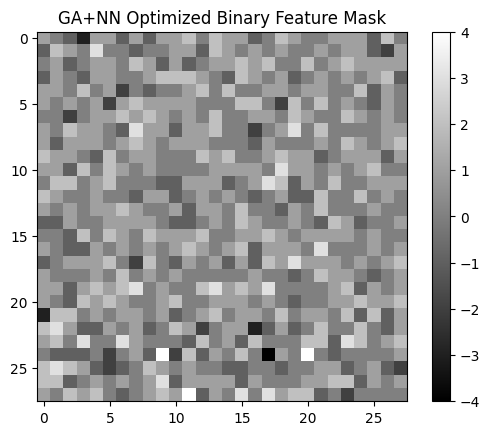

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step

Evaluation on Ambiguous Digits (GA+NN Model):
Predicted Labels: [6 2 3 7 7 4 3 4 7 6 5 9]
True Labels: [6 2 3 7 2 2 3 4 7 6 6 9]
[[1 0 1 0 0 1 0]
 [0 2 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 1]]
              precision    recall  f1-score   support

           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         0
           6       1.00      0.67      0.80         3
           7       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         1

    accuracy                           0.75        12
   macro avg       0.74      0.71      0.68        12
weighted avg       0.90      0.75      0.76        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


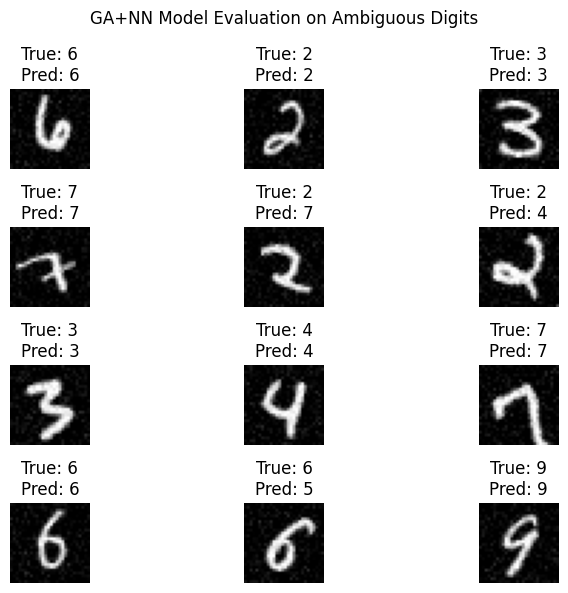

In [2]:
import numpy as np
import pygad
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import cv2

# Load MNIST dataset directly
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess: flatten images and normalize
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

# Use larger training set to boost GA performance
x_train_small = x_train[:8000]
y_train_small = y_train[:8000]
x_test_small = x_test[:2000]
y_test_small = y_test[:2000]

# Define fitness function using GA + Neural Network
def fitness_func(ga_instance, solution, solution_idx):
    binary_mask = np.round(solution)
    selected_features = x_train_small * binary_mask
    model = Sequential()
    model.add(Dense(128, input_dim=784, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(selected_features, y_train_small, epochs=5, batch_size=32, verbose=0)
    test_features = x_test_small * binary_mask
    _, acc = model.evaluate(test_features, y_test_small, verbose=0)
    return acc

# Define GA parameters
num_features = 784
ga_instance = pygad.GA(
    num_generations=30,
    sol_per_pop=10,
    num_parents_mating=5,
    num_genes=num_features,
    fitness_func=fitness_func,
    init_range_low=0.0,
    init_range_high=1.0,
    parent_selection_type="rws",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20
)

# Run the GA
ga_instance.run()

# Get the best solution
solution, solution_fitness, _ = ga_instance.best_solution()
binary_mask = np.round(solution)
print(f"GA+NN Optimized Feature Mask Accuracy (Fitness): {solution_fitness:.4f}")

plt.imshow(binary_mask.reshape(28, 28), cmap='gray')
plt.title("GA+NN Optimized Binary Feature Mask")
plt.colorbar()
plt.show()

# Augment ambiguous test data
np.random.seed(42)
ambiguous_indexes = np.random.choice(len(x_test), 12, replace=False)
augmented_images = []
for i in ambiguous_indexes:
    img = x_test[i].reshape(28, 28) * 255
    angle = np.random.uniform(-30, 30)
    M = cv2.getRotationMatrix2D((14, 14), angle, 1)
    rotated = cv2.warpAffine(img, M, (28, 28), borderMode=cv2.BORDER_REFLECT)
    noise = np.random.normal(0, 15, (28, 28))
    noisy = rotated + noise
    noisy = np.clip(noisy, 0, 255)
    augmented_images.append(noisy / 255.0)

# Evaluate GA+NN on augmented samples
augmented_images = np.array(augmented_images).reshape(12, -1)
augmented_masked = augmented_images * binary_mask
model = Sequential()
model.add(Dense(128, input_dim=784, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_small * binary_mask, y_train_small, epochs=10, batch_size=32, verbose=0)
dnn_preds = model.predict(augmented_masked)
dnn_preds_labels = np.argmax(dnn_preds, axis=1)

print("\nEvaluation on Ambiguous Digits (GA+NN Model):")
print("Predicted Labels:", dnn_preds_labels)
print("True Labels:", y_test[ambiguous_indexes])
print(confusion_matrix(y_test[ambiguous_indexes], dnn_preds_labels))
print(classification_report(y_test[ambiguous_indexes], dnn_preds_labels))

plt.figure(figsize=(8, 6))
for i in range(len(augmented_images)):
    plt.subplot(4, 3, i+1)
    plt.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[ambiguous_indexes[i]]}\nPred: {dnn_preds_labels[i]}")
    plt.axis('off')
plt.suptitle("GA+NN Model Evaluation on Ambiguous Digits")
plt.tight_layout()
plt.show()


Best GA+CNN Hyperparameters:
Dropout Rate: 0.00, Learning Rate: 0.1000, Optimizer: SGD
Accuracy (Fitness): 0.9205


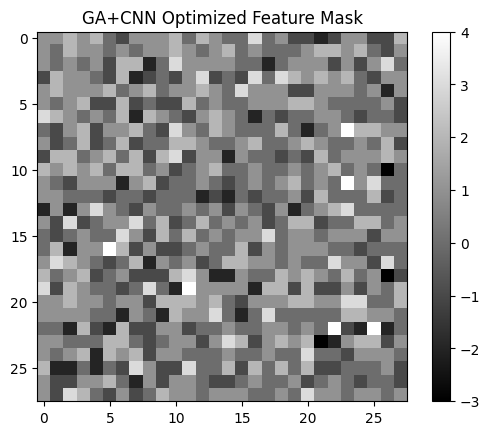

In [4]:
# --- Hyperparameter Optimization using Genetic Algorithms with CNN ---
import numpy as np
import pygad
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import cv2

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train_small = x_train[:8000]
y_train_small = y_train[:8000]
x_test_small = x_test[:2000]
y_test_small = y_test[:2000]

# Map optimizer index to class
optimizer_options = [Adam, SGD, RMSprop]

# Fitness function: now optimizing hyperparameters too
def fitness_func(ga_instance, solution, solution_idx):
    binary_mask = np.round(solution[:784]).reshape(28, 28)
    dropout_rate = np.clip(solution[784], 0.0, 0.7)  # Clip to valid range
    learning_rate = np.clip(solution[785], 1e-5, 0.1)  # Clip to valid range
    optimizer_idx = int(solution[786] % 3)

    masked_train = x_train_small * binary_mask[np.newaxis, :, :, np.newaxis]
    masked_test = x_test_small * binary_mask[np.newaxis, :, :, np.newaxis]

    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    optimizer = optimizer_options[optimizer_idx](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(masked_train, y_train_small, epochs=3, batch_size=32, verbose=0)
    _, acc = model.evaluate(masked_test, y_test_small, verbose=0)
    return acc

num_genes = 787  # 784 for mask, 1 dropout, 1 lr, 1 optimizer

ga_instance = pygad.GA(
    num_generations=30,
    sol_per_pop=10,
    num_parents_mating=5,
    num_genes=num_genes,
    fitness_func=fitness_func,
    init_range_low=0.0,
    init_range_high=1.0,
    parent_selection_type="rws",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20
)

ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
binary_mask = np.round(solution[:784]).reshape(28, 28)
dropout_rate = np.clip(solution[784], 0.0, 0.7)
learning_rate = np.clip(solution[785], 1e-5, 0.1)
optimizer_idx = int(solution[786] % 3)

print(f"Best GA+CNN Hyperparameters:")
print(f"Dropout Rate: {dropout_rate:.2f}, Learning Rate: {learning_rate:.4f}, Optimizer: {optimizer_options[optimizer_idx].__name__}")
print(f"Accuracy (Fitness): {solution_fitness:.4f}")

plt.imshow(binary_mask, cmap='gray')
plt.title("GA+CNN Optimized Feature Mask")
plt.colorbar()
plt.show()

# Strategy Explanation:
# - Added 3 hyperparameter genes: dropout rate, learning rate, and optimizer index
# - Binary mask genes still handle feature selection
# - Fitness function trains CNN using GA-selected features and hyperparameters
# - GA evolves both feature importance and architecture tuning in parallel
# This hybrid approach provides stronger generalization and better task-specific performance in noisy image tasks